In [3]:
## Standard libraries
import os
import math

import time
import glob

#Imports for model
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn import metrics
from sklearn.inspection import permutation_importance


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()


## Json decode
import json

## Use requests to get api data
import requests

In [4]:
# Decode the dictionary to create an array
def get_forecast_array(forecast_dict):
  array_dict = {}
  for key in forecast_dict[0].keys():
    for x in range(len(forecast_dict)):
      if key in array_dict:
        array_dict[key].append(forecast_dict[x][key])
      else:
        array_dict[key] = [forecast_dict[x][key]]
  return array_dict;

def extract_month(x):
     return pd.to_numeric(pd.Series(x.split('-')))

In [20]:
def create_train_test_data(hist_df,y_begin=1993, y_end=2019, m_begin=4,m_end=9):

  # get yy,mm,dd for filtering
  histdata_dates = hist_df['time'].apply(lambda x: extract_month(x))
  histdata_dates.columns = ['yy','mm','dd']
  train_all_filter = histdata_dates['yy'].isin(range(y_begin, y_end)) 
  train_summer_filter = histdata_dates['yy'].isin(range(y_begin, y_end)) & histdata_dates['mm'].isin(range(m_begin, m_end))
  test_summer_filter = histdata_dates['yy'].isin(range(y_end, 2023)) & histdata_dates['mm'].isin(range(m_begin, m_end))
  train_winter_filter = histdata_dates['yy'].isin(range(y_begin, y_end)) & \
                          (histdata_dates['mm'].isin(range(1, m_begin)) | histdata_dates['mm'].isin(range(m_end, 12)))
  test_winter_filter = histdata_dates['yy'].isin(range(y_end, 2023)) & \
                          (histdata_dates['mm'].isin(range(1, m_begin)) | histdata_dates['mm'].isin(range(m_end, 12)))

  # Extract feature
  maxtemp = hist_df['temperature_2m_max (°C)']
  mintemp = hist_df['temperature_2m_min (°C)']
  meantemp = hist_df['temperature_2m_mean (°C)']
  apptempmax = hist_df['apparent_temperature_max (°C)']#.rolling(window=1).mean()
  apptempmin = hist_df['apparent_temperature_min (°C)']#.rolling(window=1).mean()
  apptempmean = hist_df['apparent_temperature_mean (°C)']#.rolling(window=1).mean()
  prec = hist_df['precipitation_sum (mm)']#.rolling(window=3).mean()

  # Extract moving average for training
  maxtemp_sma = hist_df['temperature_2m_max (°C)'].rolling(window=5,min_periods=1).mean()
  mintemp_sma = hist_df['temperature_2m_min (°C)'].rolling(window=5,min_periods=1).mean()
  meantemp_sma = hist_df['temperature_2m_mean (°C)'].rolling(window=5,min_periods=1).mean()
  apptempmax_sma = hist_df['apparent_temperature_max (°C)'].rolling(window=5,min_periods=1).mean()
  apptempmin_sma = hist_df['apparent_temperature_min (°C)'].rolling(window=5,min_periods=1).mean()
  apptempmean_sma = hist_df['apparent_temperature_mean (°C)'].rolling(window=5,min_periods=1).mean()
  prec_sma = hist_df['precipitation_sum (mm)'].rolling(window=5,min_periods=1).mean()
  data_month = histdata_dates['mm']
  data_date = histdata_dates['dd']

  # Form train and test matrices
  X_train_all = np.column_stack([maxtemp_sma[train_all_filter],
                                    mintemp_sma[train_all_filter],
                                    meantemp_sma[train_all_filter],
                                    apptempmax_sma[train_all_filter],
                                    apptempmin_sma[train_all_filter],
                                    apptempmean_sma[train_all_filter],
                                    prec_sma[train_all_filter],
                                    data_month[train_all_filter],
                                    data_date[train_all_filter]
                                  ])
  X_train_summer = np.column_stack([maxtemp_sma[train_summer_filter],
                                    mintemp_sma[train_summer_filter],
                                    meantemp_sma[train_summer_filter],
                                    apptempmax_sma[train_summer_filter],
                                    apptempmin_sma[train_summer_filter],
                                    apptempmean_sma[train_summer_filter],
                                    prec_sma[train_summer_filter],
                                    data_month[train_summer_filter],
                                    data_date[train_summer_filter]
                                  ])

  X_train_winter = np.column_stack([maxtemp_sma[train_winter_filter],
                                    mintemp_sma[train_winter_filter],
                                    meantemp_sma[train_winter_filter],
                                    apptempmax_sma[train_winter_filter],
                                    apptempmin_sma[train_winter_filter],
                                    apptempmean_sma[train_winter_filter],
                                    prec_sma[train_winter_filter],
                                    data_month[train_winter_filter],
                                    data_date[train_winter_filter]
                                  ])

  X_test_summer = np.column_stack([maxtemp[test_summer_filter],
                                    mintemp[test_summer_filter],
                                    meantemp[test_summer_filter],
                                    apptempmax[test_summer_filter],
                                    apptempmin[test_summer_filter],
                                    apptempmean[test_summer_filter],
                                    prec[test_summer_filter],
                                    data_month[test_summer_filter],
                                    data_date[test_summer_filter]
                                  ])
  X_test_winter = np.column_stack([maxtemp[test_winter_filter],
                                    mintemp[test_winter_filter],
                                    meantemp[test_winter_filter],
                                    apptempmax[test_winter_filter],
                                    apptempmin[test_winter_filter],
                                    apptempmean[test_winter_filter],
                                    prec[test_winter_filter],
                                    data_month[test_winter_filter],
                                    data_date[test_winter_filter]
                                  ])

  return X_train_all,X_train_summer, X_train_winter, X_test_summer, X_test_winter


def train_svm(X_train):
  # OCSVM hyperparameters
  nu = 0.02
  clf = OneClassSVM(gamma='scale', kernel="rbf", nu=nu)
  clf.fit(X_train)

  y_pred_train = clf.predict(X_train)
  n_error_train = y_pred_train[y_pred_train == -1].size
  print("Training Error:", n_error_train/len(y_pred_train))

  return clf


def test_svm(clf, X_test, y_actual):
  y_pred = clf.predict(X_test)
  # Model Accuracy: how often is the classifier correct?
  print("Accuracy:",metrics.accuracy_score(y_actual, y_pred))
  return


In [21]:


# Load each municipality data and save the model
cur_dir = os.getcwd()
historical_data_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/OpenMetioHistorical_cleaned"
municipal_csv = glob.glob(historical_data_path+"/*")
model_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/github/Heat-AI/models/"
for filepath in municipal_csv:
    filename = filepath.split('/')
    mun_name = filename[-1].split('_')
    mun1_df = pd.read_csv(filepath)
    
    # train model
    X1_train, X1_train_summer, X1_train_winter, X1_test_summer, X1_test_winter = create_train_test_data(mun1_df)
    trained_model_all = train_svm(X1_train)
#     trained_model_winter = train_svm(X1_train_winter)
#     trained_model_summer = train_svm(X1_train_summer)
    
    # test model
    print("\n \nModel 1: Trained on " + mun_name[0])
    
    print ("Testing Summer post 2019")
    test_svm(trained_model_all, X1_test_summer, 1*np.ones(X1_test_summer.shape[0]))
#     test_svm(trained_model_summer, X1_test_summer, 1*np.ones(X1_test_summer.shape[0]))
#     test_svm(trained_model_winter, X1_test_summer, -1*np.ones(X1_test_summer.shape[0]))
#     print ("Testing Winter post 2019")
#     test_svm(trained_model_all, X1_test_winter, 1*np.ones(X1_test_winter.shape[0]))
#     test_svm(trained_model_summer, X1_test_winter, -1*np.ones(X1_test_winter.shape[0])) 
#     test_svm(trained_model_winter, X1_test_winter, 1*np.ones(X1_test_winter.shape[0]))
    print()
    perm_importance = permutation_importance(trained_model_all, X1_test_summer, 1*np.ones(X1_test_summer.shape[0]), scoring="accuracy")

    feature_names = ['maxtemp', 'mintemp', 'meantemp', 
                     'app_maxtem', 'app_mintemp', 'appmeantemp',
                     'prec', 'month', 'date']
    features = np.array(feature_names)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    
    plt.savefig(model_path+mun_name[0]+"__features_oneClassSVM_rbf_1993-2019_allmonths.png",bbox_inches='tight')
    plt.close()
    
#     # save model

#     model_name = mun_name[0] +"_oneClassSVM_rbf_1993-2019_allmonths.pkl"
#     with open(model_path+model_name,'wb') as f:
#         pickle.dump(trained_model_all,f)

    

Training Error: 0.019797809604043808

 
Model 1: Trained on Birendranagar
Testing Summer post 2019
Accuracy: 0.9264705882352942

Training Error: 0.020324347093513058

 
Model 1: Trained on Chaukune
Testing Summer post 2019
Accuracy: 0.9215686274509803

Training Error: 0.019903117101937658

 
Model 1: Trained on Badhaiyatal
Testing Summer post 2019
Accuracy: 0.9411764705882353

Training Error: 0.020113732097725358

 
Model 1: Trained on Chhatreshwori
Testing Summer post 2019
Accuracy: 0.8970588235294118

Training Error: 0.020324347093513058

 
Model 1: Trained on Kalimati
Testing Summer post 2019
Accuracy: 0.923202614379085

Training Error: 0.020219039595619208

 
Model 1: Trained on Lekbeshi
Testing Summer post 2019
Accuracy: 0.9705882352941176

Training Error: 0.020219039595619208

 
Model 1: Trained on Simta
Testing Summer post 2019
Accuracy: 0.9117647058823529

Training Error: 0.020008424599831508

 
Model 1: Trained on Rapti
Testing Summer post 2019
Accuracy: 0.946078431372549

Tra

In [6]:
def extract_inference_data(forecast_dict):
  inference_array = np.zeros((len(forecast_dict),9)) # number of days, number of features
  for x in range(len(forecast_dict)):
    for key in forecast_dict.columns:
      if key == "max_air_temperature":
        inference_array[x,0] = forecast_dict[key][x]
      if key == "min_air_temperature":
        inference_array[x,1] = forecast_dict[key][x]
      if key == "mean_air_temperature":
        inference_array[x,2] = forecast_dict[key][x]
      if key == "max_calculated_heat_index": #apparent temperature
        inference_array[x,3] = forecast_dict[key][x]
      if key == "min_calculated_heat_index": #apparent temperature
        inference_array[x,4] = forecast_dict[key][x]
      if key == "mean_calculated_heat_index": #apparent temperature
        inference_array[x,5] = forecast_dict[key][x]
      if key == "total precipitation": #
        inference_array[x,6] = forecast_dict[key][x]
      if key == "date":
        forecast_date = extract_month(forecast_dict[key][x])
        inference_array[x,7] = forecast_date[1]
        inference_array[x,8] = forecast_date[2]
  return inference_array


lekbeshi
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
# of outliers: 14
Badhaiyatal
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1]
# of outliers: 17
Nepalgunj
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
# of outliers: 18
Bardiya National Park
[-1 -1 -1 -1 -1 -1 -1 -

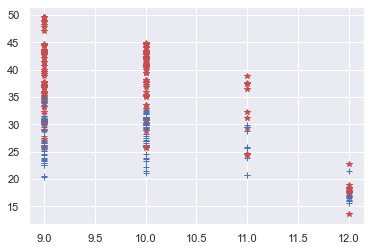

In [102]:
# testing on forecast data
forecast_data_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/municipality_forecast_csv"
municipal_csv = glob.glob(forecast_data_path+"/*")
for filepath in municipal_csv:
    filename = filepath.split('/')
    temp = filename[-1].replace('_', '.')
    mun_name = temp.split('.')
    mun1_df = pd.read_csv(filepath)
    print(mun_name[0])
    inference_array = extract_inference_data(mun1_df)
    
    #Load model
    model_path = "/Users/shreyasha/Documents/Consulting projects - Nepal/YIL - Heat AI/github/Heat-AI/models/"
    model_name = mun_name[0] +"_oneClassSVM_rbf_1993-2019_allmonths.pkl"
    with open(model_path+model_name,'rb') as f:
        trained_model = pickle.load(f)
    y_pred = trained_model.predict(inference_array)
    print(y_pred)
    index = np.where(y_pred == -1)[0]
    print("# of outliers:", len(index))
    plot_outlier(mun1_df, index)

    
    

In [100]:
def plot_outlier(df,index):
    df_dates = df['date'].apply(lambda x: extract_month(x))
    df_dates.columns = ['yy','mm','dd']
    plt.plot(df_dates['mm'][index], df["max_air_temperature"][index],'b+')
    plt.plot(df_dates['mm'][index], df["max_calculated_heat_index"][index],'r*')
    return inference_array